<a href="https://colab.research.google.com/github/Bangkit-C22-PS353-Capstone-Project/Bangkit-C22-PS353-MachineLearning/blob/main/Prediction_Beras_Bawah_II_(2_sebelum_koma)_(kg)_(Produsen_2019_2022)_Forecasting_with_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install tensorflow, Import that smooth library

In [ ]:
# import that smooth library

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import csv
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from plotly.subplots import make_subplots

In [ ]:
print(tf.__version__)
# python version : 3.6

2.8.2


# Download the Data

In [ ]:
# prepare the dataset, 
# download data from google drive
# https://drive.google.com/file/d/15yp6rCT5xE594Fic_mm_ordp7CyV5ku3/view?usp=sharing

!gdown --id 15yp6rCT5xE594Fic_mm_ordp7CyV5ku3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15yp6rCT5xE594Fic_mm_ordp7CyV5ku3
To: /content/Beras Kualitas Bawah II (2 sebelum koma) (kg) 2019-2022.csv
100% 15.6k/15.6k [00:00<00:00, 23.1MB/s]


# Preprocess the data

In [ ]:
# read the dataset and convert into csv
df = pd.read_csv('Beras Kualitas Bawah II (2 sebelum koma) (kg) 2019-2022.csv')
# show me that csv
print(df)

     Unnamed: 0        Date  Price
0             0  2019-03-01   88.0
1             1  2019-03-04   88.0
2             2  2019-03-05   89.0
3             3  2019-03-06   89.0
4             4  2019-03-08   89.0
..          ...         ...    ...
778         778  2022-04-29   83.0
779         779  2022-05-04   83.0
780         780  2022-05-05   83.5
781         781  2022-05-06   83.0
782         782  2022-05-09   85.5

[783 rows x 3 columns]


# Visualize the Dataset

In [ ]:
# put x and y axis respectively
fig = px.line(df, x='Date', y='Price')

# this code is to add the range slider so we can see better
fig.update_xaxes(rangeslider_visible=True)

# for showing the plot
fig.show()

# Setting up the plot function for plotting

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title='Price Forecasting ML Model with CNN_RNN_DNN', xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(16, 8))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Preview the Dataset

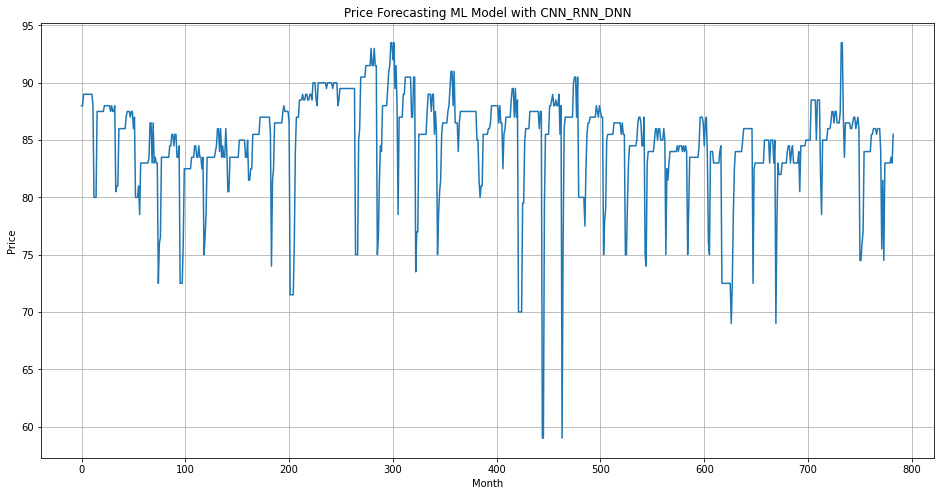

In [ ]:
# Initialize lists
time_step = []
price = []

# Open CSV file
with open('./Beras Kualitas Bawah II (2 sebelum koma) (kg) 2019-2022.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    price.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(price)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Price')

In [ ]:
print(type(time))
print(type(series))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Split the Dataset

In [ ]:
# Define the split time
split_time = 650

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

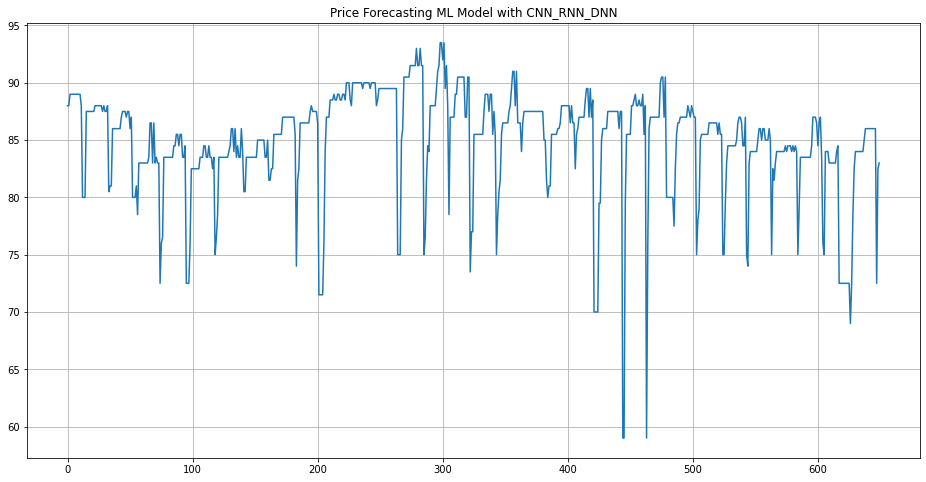

In [ ]:
# Plot the train set
plot_series(time_train, x_train)

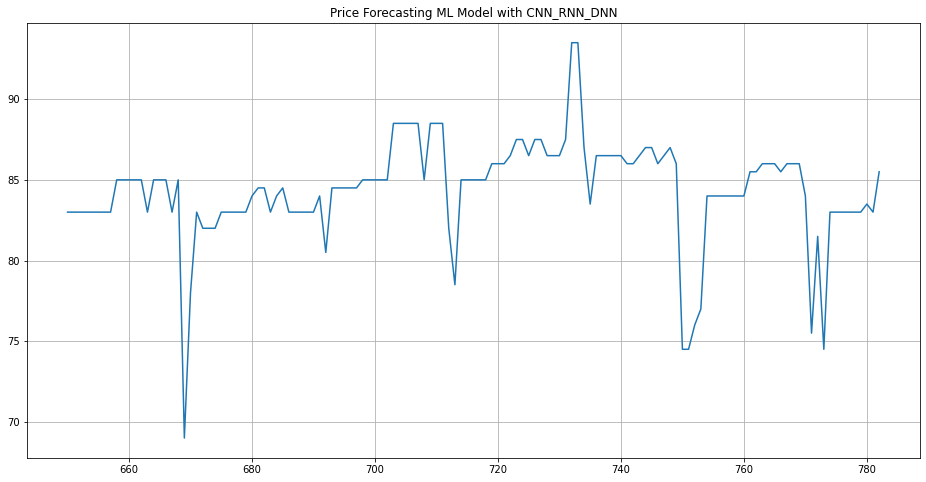

In [ ]:
# Plot the validation set
plot_series(time_valid, x_valid)

# Prepare Features and Labels

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

As mentioned in the lectures, if your results don't good, you can try tweaking the parameters here and see if the model will learn better.

In [ ]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the Model
You've seen these layers before and here is how it's looks like when combined.

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

# Tune the Learning Rate
As usual, you will want to pick an optimal learning rate.

In [ ]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
20/20 [==============================] - 3s 9ms/step - loss: 161.7663 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 154.7210 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 145.5412 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 135.8139 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 128.3381 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 121.9598 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 115.8194 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 0s 8ms/step - loss: 110.5664 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 0s 8ms/step - loss: 106.8787 - lr: 2.5119e-08
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 103.1072 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

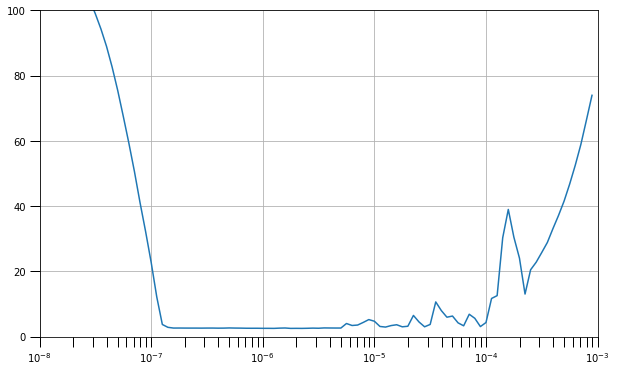

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Now let’s compile and train the model
Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
20/20 [==============================] - 3s 10ms/step - loss: 109.7097 - mae: 110.2097
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 22.3083 - mae: 22.8039
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 4.3151 - mae: 4.7941
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 2.8936 - mae: 3.3587
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 2.8422 - mae: 3.3040
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 2.8804 - mae: 3.3452
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 2.8348 - mae: 3.3026
Epoch 8/100
20/20 [==============================] - 0s 8ms/step - loss: 2.7648 - mae: 3.2289
Epoch 9/100
20/20 [==============================] - 0s 8ms/step - loss: 2.7782 - mae: 3.2397
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 2.8179 - mae: 3.2829
Epoch 11/100
20/20 [==============================] 

You can visualize the training and see if the loss and MAE are still trending down.

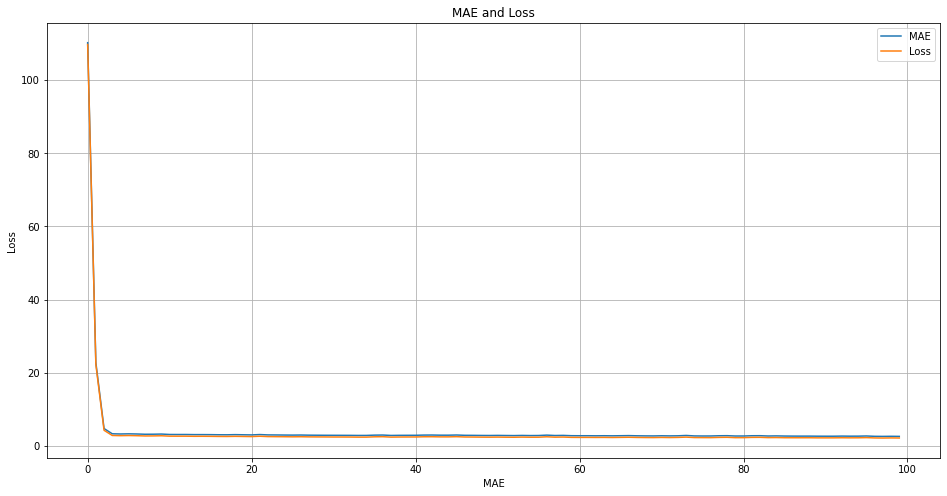

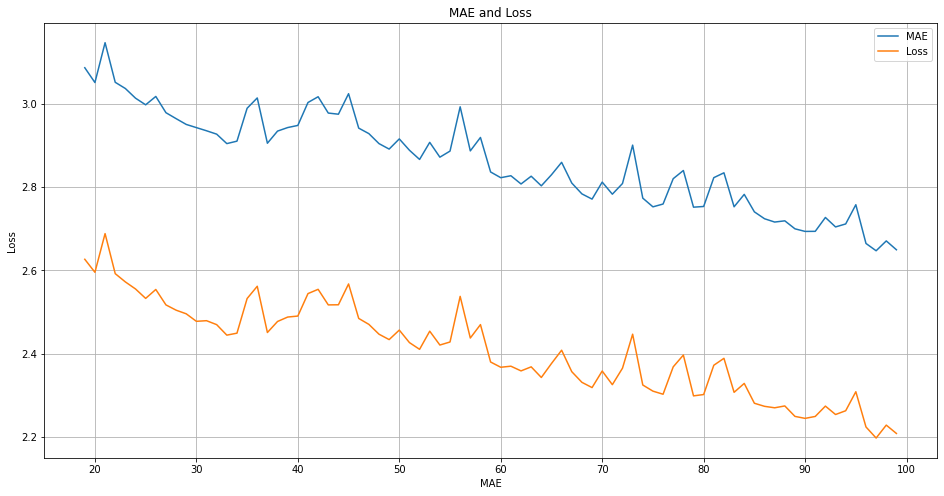

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction with Validation set

As before, you can get the predictions for the validation set time range and compute the metrics.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

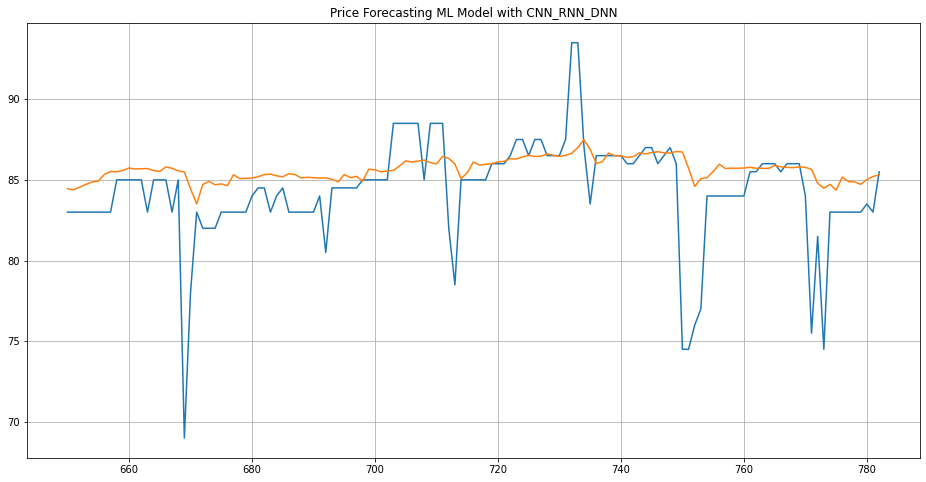

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1.9134506


## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
20/20 [==============================] - 3s 9ms/step - loss: 2.1877 - mae: 2.6389
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 2.1840 - mae: 2.6345
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1810 - mae: 2.6289
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1783 - mae: 2.6293
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1838 - mae: 2.6286
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1771 - mae: 2.6254
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1745 - mae: 2.6193
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1979 - mae: 2.6478
Epoch 9/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1798 - mae: 2.6289
Epoch 10/10
20/20 [==============================] - 0s 8ms/step - loss: 2.1754 - mae: 2.6241


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [ ]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
20/20 [==============================] - 3s 9ms/step - loss: 2.1759 - mae: 2.6238
Epoch 2/40
20/20 [==============================] - 0s 8ms/step - loss: 2.1823 - mae: 2.6318
Epoch 3/40
20/20 [==============================] - 0s 9ms/step - loss: 2.1980 - mae: 2.6426
Epoch 4/40
20/20 [==============================] - 0s 8ms/step - loss: 2.1856 - mae: 2.6317
Epoch 5/40
20/20 [==============================] - 0s 8ms/step - loss: 2.1765 - mae: 2.6266
Epoch 6/40
20/20 [==============================] - 0s 8ms/step - loss: 2.1805 - mae: 2.6229
Epoch 7/40
20/20 [==============================] - 0s 8ms/step - loss: 2.2046 - mae: 2.6507
Epoch 8/40
20/20 [==============================] - 0s 8ms/step - loss: 2.1814 - mae: 2.6298
Epoch 9/40
20/20 [==============================] - 0s 8ms/step - loss: 2.1750 - mae: 2.6200
Epoch 10/40
20/20 [==============================] - 0s 8ms/step - loss: 2.1809 - mae: 2.6313
Epoch 11/40
20/20 [==============================] - 0s 8ms/step - lo

Now see the results by geting predicitons and computing the metrics.

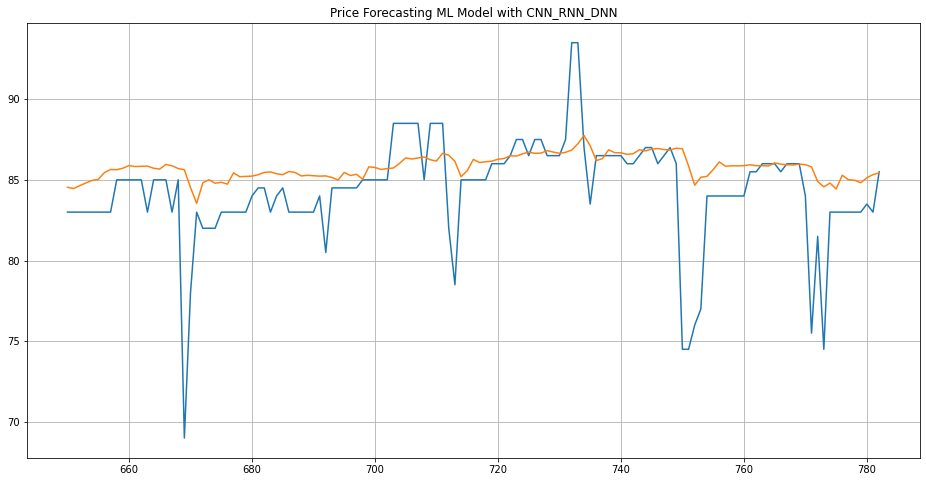

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
df_valid = pd.DataFrame({'Time_Valid': time_valid,
                   'X_Valid': x_valid,
                   'Results': results})

In [ ]:
print(df_valid)

     Time_Valid  X_Valid    Results
0           650     83.0  84.537971
1           651     83.0  84.461891
2           652     83.0  84.642303
3           653     83.0  84.811317
4           654     83.0  84.966568
..          ...      ...        ...
128         778     83.0  84.980103
129         779     83.0  84.821335
130         780     83.5  85.128319
131         781     83.0  85.324821
132         782     85.5  85.426056

[133 rows x 3 columns]


In [ ]:
fig = px.line(df_valid, x="Time_Valid", y=df_valid.columns)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [ ]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.9829097

In [ ]:
print(results[-1])

84.23176


# Forecasting Out-Of-Sample data

To predict tomorrow's value, feed into the model the past n(look_back) days’ values and we get tomorrow’s value as output. To get the day after tomorrow’s value, feed-in past n-1 days’ values along with tomorrow’s value and the model output day after tomorrow’s value.

Forecasting for longer duration is not feasible. So, let’s forecast about a months

In [ ]:
price_data = df['Price'].values
price_data = price_data.reshape((-1))

look_back = 30

def predict(num_prediction, model):
    prediction_list = price_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 45
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
print(forecast)
print(forecast_dates)

[85.5        85.74502563 85.86699677 85.82720947 85.85631561 85.87419128
 85.90296173 85.92855835 85.97982025 85.96168518 85.97694397 85.96369171
 85.96245575 85.94983673 85.97003174 85.96084595 85.95987701 85.91414642
 85.84696198 86.2126236  86.0307312  86.50500488 86.32843781 86.40447998
 86.40990448 86.46219635 86.50020599 86.55374146 86.57402039 86.67301941
 86.64835358 86.66243744 86.66261292 86.6751709  86.6837616  86.69419098
 86.70336151 86.7130661  86.72051239 86.72996521 86.7381897  86.74753571
 86.7565155  86.76662445 86.77555084 86.78529358]
[Timestamp('2022-05-09 00:00:00', freq='D'), Timestamp('2022-05-10 00:00:00', freq='D'), Timestamp('2022-05-11 00:00:00', freq='D'), Timestamp('2022-05-12 00:00:00', freq='D'), Timestamp('2022-05-13 00:00:00', freq='D'), Timestamp('2022-05-14 00:00:00', freq='D'), Timestamp('2022-05-15 00:00:00', freq='D'), Timestamp('2022-05-16 00:00:00', freq='D'), Timestamp('2022-05-17 00:00:00', freq='D'), Timestamp('2022-05-18 00:00:00', freq='D')

In [ ]:
print(forecast[45:46])
print(forecast_dates[45:46])

[86.78529358]
[Timestamp('2022-06-23 00:00:00', freq='D')]


In [ ]:
# Masukkin ke dataframe

df_forecast = pd.DataFrame({'Time_forecast': forecast_dates,
                   'Forecast': forecast})

df_forecast['Time_forecast'] = pd.to_datetime(df_forecast['Time_forecast'])

df_forecast['Time'] = df_forecast['Time_forecast'].dt.date

np.append(series, df_forecast['Forecast'])

df_pre = pd.DataFrame({'Time': df['Date'].append(df_forecast['Time']),
                   'Actual': np.append(series, df_forecast['Forecast'])})

df_pre = df_pre.append(df_forecast)

df_pre.drop(['Time_forecast'], axis=1, inplace=True)

df_pre.reset_index(drop=True, inplace=True)

In [ ]:
print(df_pre)

           Time  Actual   Forecast
0    2019-03-01    88.0        NaN
1    2019-03-04    88.0        NaN
2    2019-03-05    89.0        NaN
3    2019-03-06    89.0        NaN
4    2019-03-08    89.0        NaN
..          ...     ...        ...
870  2022-06-19     NaN  86.747536
871  2022-06-20     NaN  86.756516
872  2022-06-21     NaN  86.766624
873  2022-06-22     NaN  86.775551
874  2022-06-23     NaN  86.785294

[875 rows x 3 columns]


In [ ]:
fig = px.line(df, x='Date', y='Price')
fig.add_scatter(x=df_pre['Time'], y=df_pre['Forecast'], mode='lines')

fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [ ]:
fig2 = px.line(df_forecast, x='Time', y='Forecast')

fig2.update_xaxes(rangeslider_visible=True)

fig2.show()

# Save model to h5 format

In [ ]:
model.save('forecasting_model.h5')

from google.colab import files
files.download('forecasting_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Save Model to folder

In [ ]:
from tensorflow import keras

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("my_model")

# save to zip
!zip -r /content/my_model.zip /content/my_model
files.download("/content/my_model.zip")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


  adding: content/my_model/ (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 91%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/my_model/variables/variables.index (deflated 68%)
  adding: content/my_model/keras_metadata.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>